In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arumugasundar007","key":"2e8c7c768e290af709d59603c465a312"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c malware-analysis-hackathon

 95% 130M/137M [00:00<00:00, 143MB/s]
100% 137M/137M [00:00<00:00, 156MB/s]


In [ ]:
!unzip malware-analysis-hackathon.zip

Archive:  malware-analysis-hackathon.zip
  inflating: evaluation_dataset/evaluation_dataset/evaluation_hardware_trails  
  inflating: evaluation_dataset/evaluation_dataset/evaluation_network_trails  
  inflating: evaluation_dataset/evaluation_dataset/evaluation_os_trails  
  inflating: train_dataset/train_dataset/training_hardware_trails  
  inflating: train_dataset/train_dataset/training_network_trails  
  inflating: train_dataset/train_dataset/training_os_trails  


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
file_path = '/content/train_dataset/train_dataset/training_network_trails'
df_s1 = pd.read_csv(file_path, sep="," )

In [ ]:
print(df_s1['goal'].isna().any(), df_s1['goal'].isna().sum())

False 0


In [ ]:
df_s1.head()

,Unnamed: 0,Filename,#Src_IP,DestIP,Dport,Protocol,service,sportcounts,number_of_flows,average_of_duration,...,bkdoor,infosteal,rootkits,method_encoded,goal_encoded,family_encoded,infosteal_encoded,Src_P,Dest_IP,Dest_P
0,0,0e226971d45ce6d098ee17708a600968.csv,192168002027,1.921680e+11,443.0,1.0,1.0,42.0,42,0.570197,...,0,0,0,6,2,2,0,NaN,NaN,NaN
1,1,0e226971d45ce6d098ee17708a600968.csv,192168002027,2.019015e+10,443.0,1.0,1.0,2.0,2,0.477187,...,0,0,0,6,2,2,0,NaN,NaN,NaN
2,2,0e226971d45ce6d098ee17708a600968.csv,192168002027,1.921680e+11,80.0,1.0,2.0,22.0,11,0.020942,...,0,0,0,6,2,2,0,NaN,NaN,NaN
3,3,0e226971d45ce6d098ee17708a600968.csv,192168002027,2.019015e+10,443.0,1.0,0.0,1.0,1,0.001484,...,0,0,0,6,2,2,0,NaN,NaN,NaN
4,4,0e226971d45ce6d098ee17708a600968.csv,192168002027,1.921680e+11,53.0,2.0,3.0,24.0,24,0.012518,...,0,0,0,6,2,2,0,NaN,NaN,NaN


In [ ]:
df_s1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9837 entries, 0 to 9836
Columns: 105 entries, Unnamed: 0 to Dest_P
dtypes: float64(61), int64(29), object(15)
memory usage: 7.9+ MB


In [ ]:
df_s1['goal'].value_counts()

,count
goal,
pua,3296
downloader,1929
deceptor,1872
normal,947
backdoor,942
cryptominer,453
spyware,193
banker,110
ransomware,95


In [ ]:
unique_columns = [col for col in df_s1.columns if df_s1[col].nunique() == 1]
print(unique_columns)

['SNI_equal_DstIP', 'interarrival_time', 'hostname_caseratio', 'sni_caseratio', 'dns_nxdomain_caseratio', 'dns_success_caseratio', 'label', 'infosteal', 'rootkits', 'infosteal_encoded']


In [ ]:
# Columns to remove
# Unnamed: 0 & Filename also seems to be not relavant for predection
# Src_P,Dest_IP,Dest_P seems to be having minimal impact with more null values

columns_to_remove = [
    'Unnamed: 0', 'Filename',
    'SNI_equal_DstIP', 'interarrival_time', 'hostname_caseratio', 'sni_caseratio', 'dns_nxdomain_caseratio', 'dns_success_caseratio', 'label', 'infosteal', 'rootkits', 'infosteal_encoded',
    'Src_P','Dest_IP','Dest_P',
    'family_gene', 'method', 'family_label', 'filename',
    'full_label', # have to be added later
    'standart_deviation_cert_length', 'is_SNIs_in_SNA_dns', # values matching with 'is_valid_certificate_during_capture'
    'url_query_names', 'url_query_values', # values may be needful but just eliminated for random forest classifier
    'path', # most of the records are [] , (empty)
    'url_path_length', 'number_of_URL_query_parameters', 'number_of_uploaded_bytes', 'filename_length', # mostly 0
    'noOffiles', 'filename_digitratio', 'filename_alpharatio', 'filename_specialcharratio', 'filename_caseratio', 'filename_vowelchangeratio', # mostly 0
    'urlspecialcharratio', 'urlcaseratio', 'hostname_digitratio', 'hostname_alpharatio', 'hostname_specialcharratio', 'sni_digitratio', # mostly 0
    'dns_success_digitratio', 'dns_success_alpharatio', 'dns_success_specialcharratio', 'dns_success_vowelchangeratio', 'dns_nxdomain', 'dns_status_ratio', # mostly 0
    'cert_subject', 'cert_issuer', 'goal_encoded' # very rarely impact the attack
    ]

# Drop the specified columns
df_s2 = df_s1.drop(columns=columns_to_remove)

In [ ]:
print(df_s2['goal'].isna().any(), df_s2['goal'].isna().sum())

False 0


In [ ]:
df_s2.head()

,#Src_IP,DestIP,Dport,Protocol,service,sportcounts,number_of_flows,average_of_duration,standard_deviation_duration,percent_of_standard_deviation_duration,...,dns_nxdomain_specialcharratio,dns_nxdomain_vowelchangeratio,dns_noerror,dns_othererrors,binarylabel,goal,keylog,bkdoor,method_encoded,family_encoded
0,192168002027,1.921680e+11,443.0,1.0,1.0,42.0,42,0.570197,0.902680,0.261905,...,0.000000,0.000000,0.0,0.0,1,backdoor,0,0,6,2
1,192168002027,2.019015e+10,443.0,1.0,1.0,2.0,2,0.477187,0.002039,0.000000,...,0.000000,0.000000,0.0,0.0,1,backdoor,0,0,6,2
2,192168002027,1.921680e+11,80.0,1.0,2.0,22.0,11,0.020942,0.002781,0.272727,...,0.000000,0.000000,0.0,0.0,1,backdoor,0,0,6,2
3,192168002027,2.019015e+10,443.0,1.0,0.0,1.0,1,0.001484,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,1,backdoor,0,0,6,2
4,192168002027,1.921680e+11,53.0,2.0,3.0,24.0,24,0.012518,0.002551,0.208333,...,0.155464,0.513317,24.0,0.0,1,backdoor,0,0,6,2


In [ ]:
# Src_P,Dest_IP,Dest_P
print(df_s2['goal'].value_counts())
# print(df_s2['Src_P'].value_counts())
# print(df_s2['Dest_IP'].value_counts())
# print(df_s2['Dest_P'].value_counts())
# print(df_s2['family_gene'].value_counts())
# print(df_s2['method'].value_counts())
# print(df_s2['family_label'].value_counts())
# print(df_s2['filename'].value_counts()) # more of empty values
print(df_s2['full_label'].value_counts())
# print(df_s2['family_gene'].value_counts())
print(df_s2['keylog'].value_counts())

goal
pua            3296
downloader     1929
deceptor       1872
normal          947
backdoor        942
cryptominer     453
spyware         193
banker          110
ransomware       95
Name: count, dtype: int64
full_label
PUA                                 3296
DECEPTOR                            1872
CLEAN                                947
MSIL.Agent.R_                        840
Win32.TrojanDownloader.Agent.E__     776
Win32.TrojanDownloader.Agent.D__     732
Win32_Agent.T__                      360
Win32.CoinMiner.I                    255
Win32.CoinMiner.SC                   198
Win32.Spy.Buhtrap                    111
Win32.Emotet.B_                      110
Win.32Delf.B__                        79
Win32.TrojanDownloader.Chindo.D       61
Win32.Spy.Agent.P__                   60
Python.Filecoder                      42
Win32.Filecoder.Rapid.A               29
Win32.Filecoder.Ouroboros             24
Win32.Corebot                         23
Win32/Kryptik.GLRK                    12

In [ ]:
columns_with_minimal_unique_values = df_s2.columns[df_s2.nunique() <= 20]

df_s3 = df_s2[columns_with_minimal_unique_values]

In [ ]:
print(columns_with_minimal_unique_values)

Index(['#Src_IP', 'Protocol', 'service', 'percent_of_established_states',
       'ssl_ratio', 'average_public_key', 'tls_version_ratio',
       'average_of_certificate_length', 'is_valid_certificate_during_capture',
       'amount_diff_certificates', 'number_of_domains_in_certificate',
       'number_of_certificate_path', 'x509_ssl_ratio', 'SNI_ssl_ratio',
       'self_signed_ratio', 'is_CNs_in_SNA_dns', 'number_of_url_flows',
       'number_of_downloaded_bytes', 'sni_alpharatio', 'sni_specialcharratio',
       'sni_vowelchangeratio', 'binarylabel', 'goal', 'keylog', 'bkdoor',
       'method_encoded', 'family_encoded'],
      dtype='object')


In [ ]:
# '#Src_IP', 'Protocol', 'service', 'percent_of_established_states', 'ssl_ratio'
# print(df_s2['#Src_IP'].value_counts())
# print(df_s2['Protocol'].value_counts())
# print(df_s2['service'].value_counts())
# print(df_s2['percent_of_established_states'].value_counts())
# print(df_s2['ssl_ratio'].value_counts())

# 'average_public_key', 'tls_version_ratio', 'average_of_certificate_length', 'is_valid_certificate_during_capture'
# print(df_s2['average_public_key'].value_counts())
# print(df_s2['tls_version_ratio'].value_counts())
# print(df_s2['average_of_certificate_length'].value_counts())
# print(df_s2['is_valid_certificate_during_capture'].value_counts())

# (df_s6['standart_deviation_cert_length'] == df_s6['is_valid_certificate_during_capture']).all()

# 'amount_diff_certificates', 'number_of_domains_in_certificate', 'number_of_certificate_path', 'x509_ssl_ratio', 'SNI_ssl_ratio'
# print(df_s2['amount_diff_certificates'].value_counts())
# print(df_s2['number_of_domains_in_certificate'].value_counts())
# print(df_s2['number_of_certificate_path'].value_counts())
# print(df_s2['x509_ssl_ratio'].value_counts())
# print(df_s2['SNI_ssl_ratio'].value_counts())

# 'self_signed_ratio', 'is_CNs_in_SNA_dns'
# print(df_s2['self_signed_ratio'].value_counts())
# print(df_s2['is_CNs_in_SNA_dns'].value_counts())

# causing error with random forest
# print(df_s2['url_query_names'].value_counts())
# print(df_s2['url_query_values'].value_counts())

# (df_s2['is_SNIs_in_SNA_dns'] == df_s2['is_CNs_in_SNA_dns']).all()

# 'path', 'url_path_length', 'number_of_URL_query_parameters', 'filename_length', 'number_of_url_flows', 'number_of_downloaded_bytes', 'number_of_uploaded_bytes'
# print(df_s2['number_of_url_flows'].value_counts())
# print(df_s2['number_of_downloaded_bytes'].value_counts())

# removed - having more 0 & [], (empty)
# print(df_s2['path'].value_counts())
# print(df_s2['url_path_length'].value_counts())
# print(df_s2['number_of_URL_query_parameters'].value_counts())
# print(df_s2['filename_length'].value_counts())
# print(df_s2['number_of_uploaded_bytes'].value_counts())

# 'noOffiles', 'filename_digitratio', 'filename_alpharatio', 'filename_specialcharratio', 'filename_caseratio', 'filename_vowelchangeratio'

# removed - having more 0
# print(df_s2['noOffiles'].value_counts())
# print(df_s2['filename_digitratio'].value_counts())
# print(df_s2['filename_alpharatio'].value_counts())
# print(df_s2['filename_specialcharratio'].value_counts())
# print(df_s2['filename_caseratio'].value_counts())
# print(df_s2['filename_vowelchangeratio'].value_counts())

# 'urlspecialcharratio', 'urlcaseratio', 'hostname_digitratio', 'hostname_alpharatio', 'hostname_specialcharratio', 'sni_digitratio'

# removed - having more 0
# print(df_s2['urlspecialcharratio'].value_counts())
# print(df_s2['urlcaseratio'].value_counts())
# print(df_s2['hostname_digitratio'].value_counts())
# print(df_s2['hostname_alpharatio'].value_counts())
# print(df_s2['hostname_specialcharratio'].value_counts())
# print(df_s2['sni_digitratio'].value_counts())

# 'dns_success_digitratio', 'dns_success_alpharatio', 'dns_success_specialcharratio', 'dns_success_vowelchangeratio', 'dns_nxdomain', 'dns_status_ratio'

# removed - having more 0
# print(df_s2['dns_success_digitratio'].value_counts())
# print(df_s2['dns_success_alpharatio'].value_counts())
# print(df_s2['dns_success_specialcharratio'].value_counts())
# print(df_s2['dns_success_vowelchangeratio'].value_counts())
# print(df_s2['dns_nxdomain'].value_counts())
# print(df_s2['dns_status_ratio'].value_counts())

# 'cert_subject', 'cert_issuer'

# removed - very rarely impact the attack
# print(df_s2['cert_subject'].value_counts())
# print(df_s2['cert_issuer'].value_counts())

print(df_s2['cert_subject'].isna().any(), df_s2['cert_subject'].isna().sum())



True 8861


In [ ]:
# Just to conclude like cert_subject & cert_issuer is very rarely impact the attack

# Filter the DataFrame to get only rows where 'cert_subject' is not NaN
filtered_df = df_s2[df_s2['cert_subject'].notna()]
# filtered_df = df_s2[df_s2['cert_issuer'].notna()]

# Count total rows in the filtered DataFrame
total_rows = len(filtered_df)

# Count rows where 'goal' is 'normal'
normal_count = (filtered_df['goal'] == 'normal').sum()

# Calculate percentage
percentage_normal = (normal_count / total_rows) * 100 if total_rows > 0 else 0

print(f"Percentage of 'normal' goal when 'cert_subject' is not NaN: {percentage_normal:.2f}%")

Percentage of 'normal' goal when 'cert_subject' is not NaN: 4.10%


In [ ]:
print(df_s3['goal'].isna().any(), df_s3['goal'].isna().sum())

False 0


In [ ]:
df_s3.head()

,#Src_IP,Protocol,service,percent_of_established_states,ssl_ratio,average_public_key,tls_version_ratio,average_of_certificate_length,is_valid_certificate_during_capture,amount_diff_certificates,...,number_of_downloaded_bytes,sni_alpharatio,sni_specialcharratio,sni_vowelchangeratio,binarylabel,goal,keylog,bkdoor,method_encoded,family_encoded
0,192168002027,1.0,1.0,1.0,0.0,2048.0,1.0,3650.0,0,1,...,0,0.863636,0.136364,0.357143,1,backdoor,0,0,6,2
1,192168002027,1.0,1.0,1.0,0.0,2048.0,1.0,365.0,0,1,...,0,0.857143,0.142857,0.714286,1,backdoor,0,0,6,2
2,192168002027,1.0,2.0,1.0,-1.0,-1.0,-1.0,-1.0,-1,0,...,97,0.000000,0.000000,0.000000,1,backdoor,0,0,6,2
3,192168002027,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1,0,...,0,0.000000,0.000000,0.000000,1,backdoor,0,0,6,2
4,192168002027,2.0,3.0,1.0,-1.0,-1.0,-1.0,-1.0,-1,0,...,0,0.000000,0.000000,0.000000,1,backdoor,0,0,6,2


In [ ]:
# df_s4 = df_s3.replace("", np.nan)
# df_s5 = df_s4.dropna(axis=1, thresh=int(0.5*len(df_s4)))
# print(df_s5['goal'].isna().any(), df_s5['goal'].isna().sum())
# df_s6 = df_s5.apply(lambda col: pd.to_numeric(col, errors='coerce')).copy()

False 0


In [ ]:
# print(y.isna().sum())
# print(df_s6['goal'].isna().any(), df_s6['goal'].isna().sum())

True 9837


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# For accuracy test purpose

# Features (excluding the target variable)
X = df_s3.drop(columns=['goal'])  # Drop the target and non-numeric columns if needed

# Target variable
y = df_s3['goal']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9722222222222222
Classification Report:
              precision    recall  f1-score   support

    backdoor       0.80      0.98      0.88       294
      banker       1.00      0.97      0.99        35
 cryptominer       1.00      0.98      0.99       131
    deceptor       1.00      1.00      1.00       555
  downloader       0.99      0.88      0.93       614
      normal       1.00      1.00      1.00       271
         pua       1.00      1.00      1.00       967
  ransomware       1.00      1.00      1.00        24
     spyware       0.98      1.00      0.99        61

    accuracy                           0.97      2952
   macro avg       0.97      0.98      0.98      2952
weighted avg       0.98      0.97      0.97      2952



In [ ]:
file_path = '/content/evaluation_dataset/evaluation_dataset/evaluation_network_trails'
ev_df = pd.read_csv(file_path)

In [ ]:
ev_df.head()

,Unnamed: 0,Filename,#Src_IP,DestIP,Dport,Protocol,service,sportcounts,number_of_flows,average_of_duration,...,method,family_gene,keylog,bkdoor,infosteal,rootkits,method_encoded,goal_encoded,family_encoded,infosteal_encoded
0,0,c5b1e4d675be2758c0ae1860a206bfce.csv,192168002027,192168003001,443,1,1,2,2,1.210549,...,trojan,Coinminer,0,0,0,0,2,4,24,0
1,1,c5b1e4d675be2758c0ae1860a206bfce.csv,192168002027,192168003001,80,1,2,182,91,0.021070,...,trojan,Coinminer,0,0,0,0,2,4,24,0
2,2,c5b1e4d675be2758c0ae1860a206bfce.csv,192168002027,192168003001,5938,1,0,218,218,0.000020,...,trojan,Coinminer,0,0,0,0,2,4,24,0
3,3,c5b1e4d675be2758c0ae1860a206bfce.csv,192168002027,192168003001,443,1,0,44,44,0.012988,...,trojan,Coinminer,0,0,0,0,2,4,24,0
4,4,c5b1e4d675be2758c0ae1860a206bfce.csv,192168002027,192168003001,53,2,3,29,29,0.011545,...,trojan,Coinminer,0,0,0,0,2,4,24,0


In [ ]:
# For model submission

# Features (excluding the target variable)
X = df_s3.drop(columns=['goal'])  # Drop the target and non-numeric columns if needed

# Target variable
y = df_s3['goal']

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X, y)

columns_to_use = ['#Src_IP', 'Protocol', 'service', 'percent_of_established_states',
       'ssl_ratio', 'average_public_key', 'tls_version_ratio',
       'average_of_certificate_length', 'is_valid_certificate_during_capture',
       'amount_diff_certificates', 'number_of_domains_in_certificate',
       'number_of_certificate_path', 'x509_ssl_ratio', 'SNI_ssl_ratio',
       'self_signed_ratio', 'is_CNs_in_SNA_dns', 'number_of_url_flows',
       'number_of_downloaded_bytes', 'sni_alpharatio', 'sni_specialcharratio',
       'sni_vowelchangeratio', 'binarylabel', 'keylog', 'bkdoor',
       'method_encoded', 'family_encoded']

X_test = ev_df[columns_to_use]

# Make predictions
y_pred = rf_classifier.predict(X_test)

print(y_pred)

['cryptominer' 'cryptominer' 'cryptominer' ... 'normal' 'normal' 'normal']


In [ ]:
num_records = ev_df.shape[0]
print(num_records, len(y_pred))

2475 2475


In [ ]:
df = pd.DataFrame({
    'Id': range(1, len(y_pred) + 1),  # Create a sequence of IDs starting from 1
    'Goal': y_pred
})

# Save the DataFrame to a CSV file
df.to_csv('submission_network.csv', index=False)

from google.colab import files
files.download('submission_network.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

In [ ]:
file_path = '/content/train_dataset/train_dataset/training_network_trails'
tf_df = pd.read_csv(file_path, sep="," )

TypeError: 'value' must be an instance of str or bytes, not a float

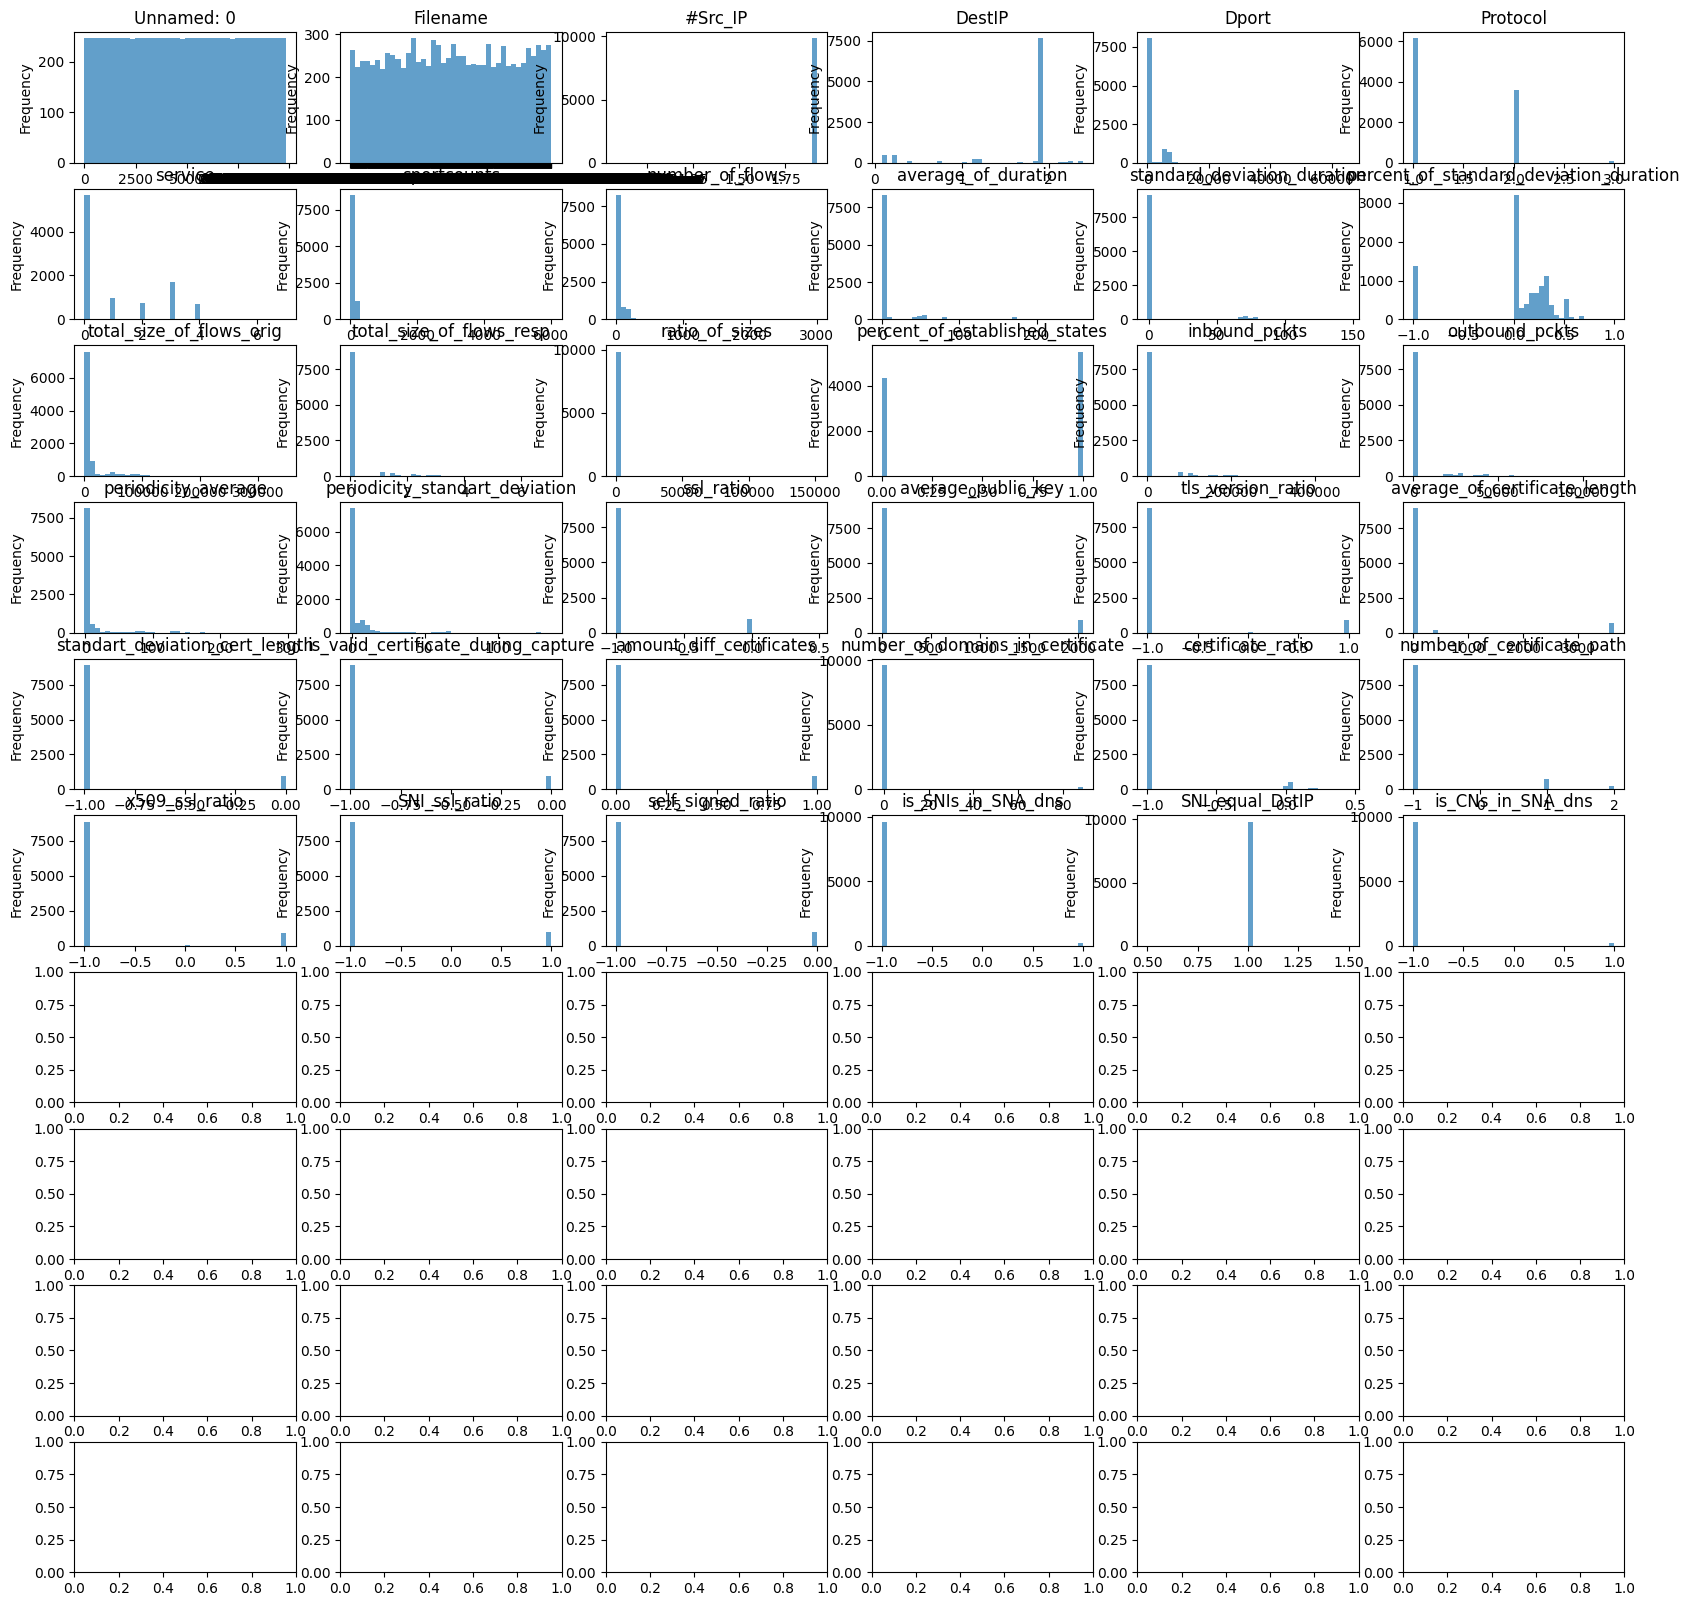

In [ ]:
features = tf_df.drop(columns=['goal']).columns

# Set up the number of rows and columns for subplots
n_rows = 10   # Number of rows for subplots
n_cols = 6    # Number of columns for subplots

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Adjust size based on features

# Flatten the axes array to easily index them
axes = axes.flatten()

# Loop through each feature and plot a histogram in the corresponding subplot
for i, feature in enumerate(features):
    axes[i].hist(tf_df[feature], bins=40, alpha=0.7, label=feature)
    axes[i].set_title(feature)  # Set title for each feature
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Remove any extra subplots that don't have any data
for i in range(len(features), n_rows * n_cols):
    fig.delaxes(axes[i])

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
columns_to_remove = [
    'Unnamed: 0', 'Filename',
    'SNI_equal_DstIP', 'interarrival_time', 'hostname_caseratio', 'sni_caseratio', 'dns_nxdomain_caseratio', 'dns_success_caseratio', 'label', 'infosteal', 'rootkits', 'infosteal_encoded',
    'Src_P','Dest_IP','Dest_P',
    'family_gene', 'method', 'family_label', 'filename',
    'full_label', # have to be added later
    'standart_deviation_cert_length', 'is_SNIs_in_SNA_dns', # values matching with 'is_valid_certificate_during_capture'
    'url_query_names', 'url_query_values', # values may be needful but just eliminated for random forest classifier
    'path', # most of the records are [] , (empty)
    'url_path_length', 'number_of_URL_query_parameters', 'number_of_uploaded_bytes', 'filename_length', # mostly 0
    'noOffiles', 'filename_digitratio', 'filename_alpharatio', 'filename_specialcharratio', 'filename_caseratio', 'filename_vowelchangeratio', # mostly 0
    'urlspecialcharratio', 'urlcaseratio', 'hostname_digitratio', 'hostname_alpharatio', 'hostname_specialcharratio', 'sni_digitratio', # mostly 0
    'dns_success_digitratio', 'dns_success_alpharatio', 'dns_success_specialcharratio', 'dns_success_vowelchangeratio', 'dns_nxdomain', 'dns_status_ratio', # mostly 0
    'cert_subject', 'cert_issuer' # very rarely impact the attack
    ]
tf_df = tf_df.drop(columns=columns_to_remove)
columns_with_minimal_unique_values = tf_df.columns[tf_df.nunique() <= 20]
tf_df = tf_df[columns_with_minimal_unique_values]

In [ ]:
columns_with_minimal_unique_values

Index(['#Src_IP', 'Protocol', 'service', 'percent_of_established_states',
       'ssl_ratio', 'average_public_key', 'tls_version_ratio',
       'average_of_certificate_length', 'is_valid_certificate_during_capture',
       'amount_diff_certificates', 'number_of_domains_in_certificate',
       'number_of_certificate_path', 'x509_ssl_ratio', 'SNI_ssl_ratio',
       'self_signed_ratio', 'is_CNs_in_SNA_dns', 'number_of_url_flows',
       'number_of_downloaded_bytes', 'sni_alpharatio', 'sni_specialcharratio',
       'sni_vowelchangeratio', 'binarylabel', 'goal', 'keylog', 'bkdoor',
       'method_encoded', 'goal_encoded', 'family_encoded'],
      dtype='object')

In [ ]:
X = tf_df.drop(columns=['goal']).values
y = tf_df['goal'].values

X,y

(array([[1.92168002e+11, 1.00000000e+00, 1.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 1.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 2.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        ...,
        [1.92168002e+11, 1.00000000e+00, 0.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 0.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 0.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00]]),
 array(['backdoor', 'backdoor', 'backdoor', ..., 'backdoor', 'backdoor',
        'backdoor'], dtype=object))

In [ ]:
X.shape, y.shape

((9837, 27), (9837,))

In [ ]:
# also try excluding this

# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# data = np.hstack((X, np.reshape(y, (-1,1))))
# tf_df = pd.DataFrame(data, columns=tf_df.columns)

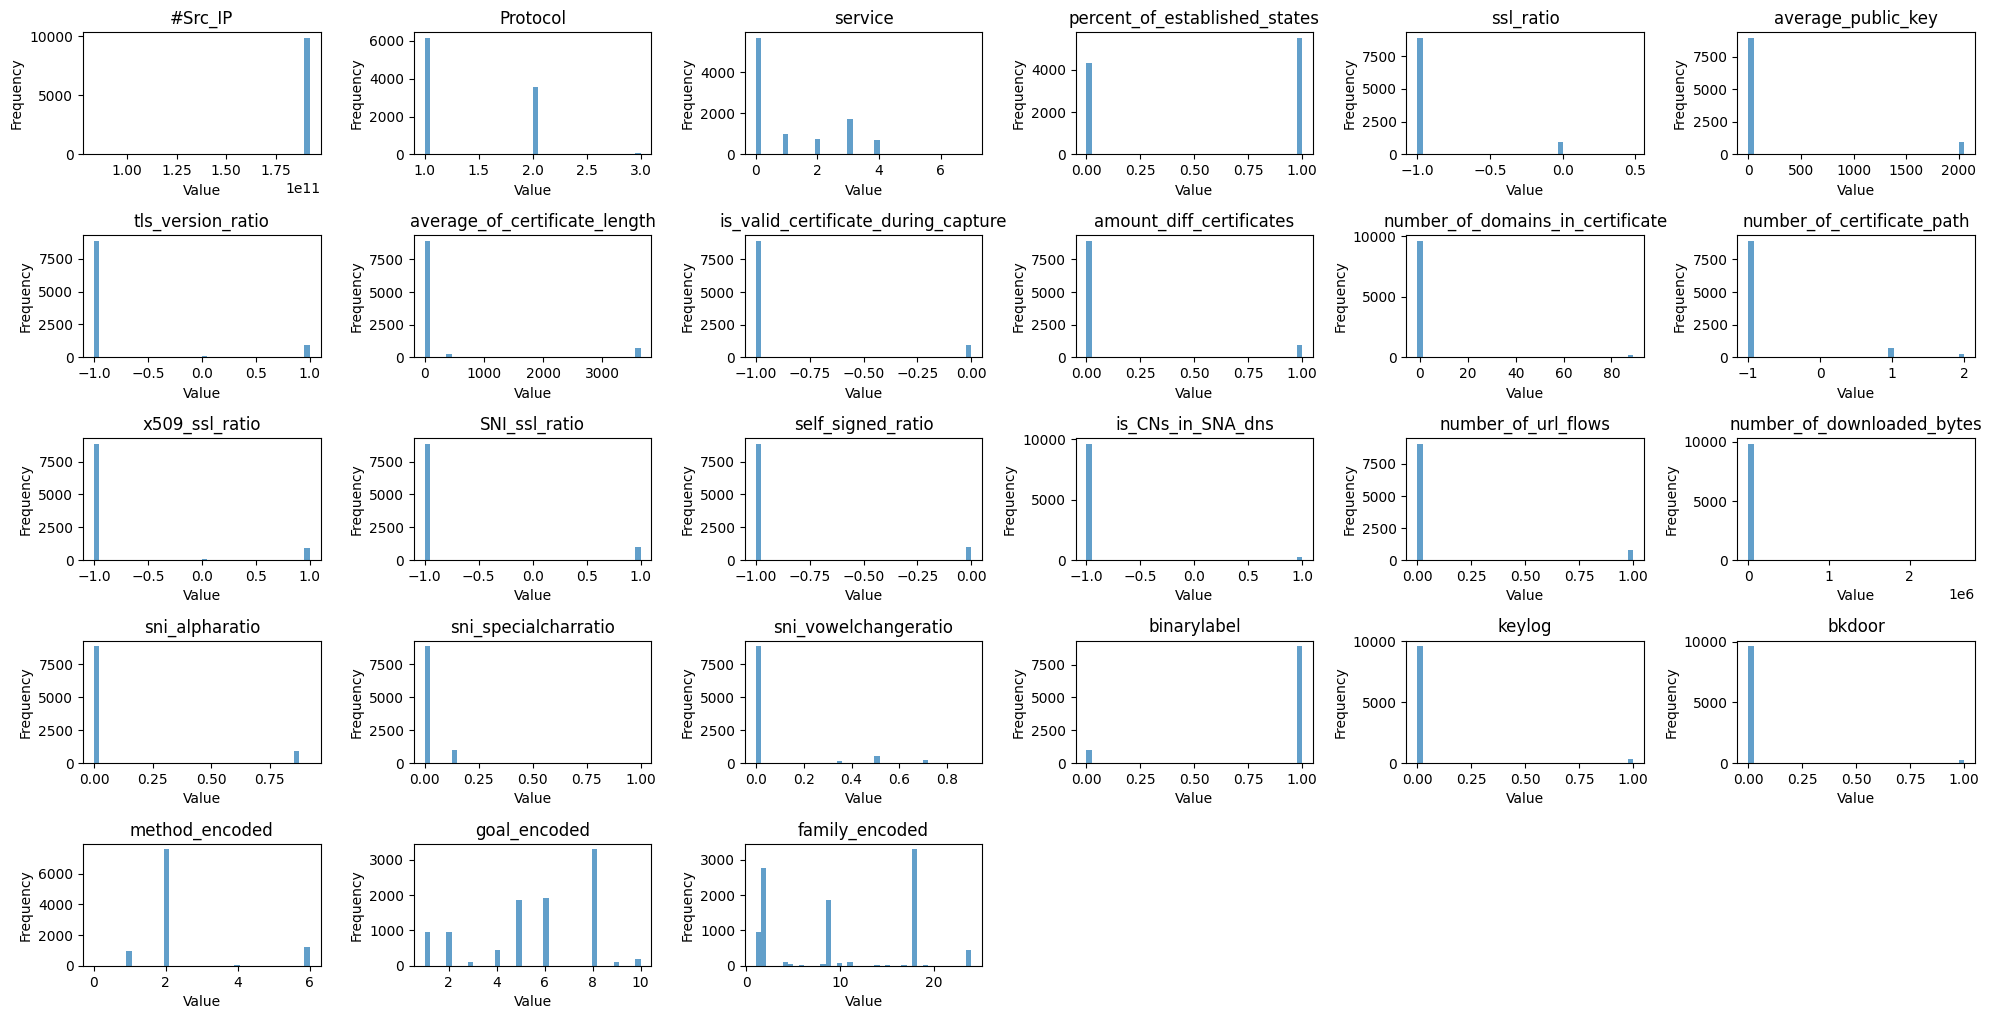

In [ ]:
features = tf_df.drop(columns=['goal']).columns

# Set up the number of rows and columns for subplots
n_rows = 10   # Number of rows for subplots
n_cols = 6    # Number of columns for subplots

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Adjust size based on features

# Flatten the axes array to easily index them
axes = axes.flatten()

# Loop through each feature and plot a histogram in the corresponding subplot
for i, feature in enumerate(features):
    axes[i].hist(tf_df[feature], bins=40, alpha=0.7, label=feature)
    axes[i].set_title(feature)  # Set title for each feature
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Remove any extra subplots that don't have any data
for i in range(len(features), n_rows * n_cols):
    fig.delaxes(axes[i])

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
X, y

(array([[1.92168002e+11, 1.00000000e+00, 1.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 1.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 2.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        ...,
        [1.92168002e+11, 1.00000000e+00, 0.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 0.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00],
        [1.92168002e+11, 1.00000000e+00, 0.00000000e+00, ...,
         6.00000000e+00, 2.00000000e+00, 2.00000000e+00]]),
 array(['backdoor', 'backdoor', 'backdoor', ..., 'backdoor', 'backdoor',
        'backdoor'], dtype=object))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert target to numerical form
y_test = label_encoder.transform(y_test)

In [ ]:
num_classes=9
model = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1057 - loss: nan - val_accuracy: 0.0996 - val_loss: nan
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0931 - loss: nan - val_accuracy: 0.0996 - val_loss: nan
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0949 - loss: nan - val_accuracy: 0.0996 - val_loss: nan
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0891 - loss: nan - val_accuracy: 0.0996 - val_loss: nan
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0972 - loss: nan - val_accuracy: 0.0996 - val_loss: nan


In [ ]:
model.evaluate(X_test, y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0983 - loss: nan


[nan, 0.09959349781274796]

In [ ]:
y_pred = model.predict(X_test)
y_pred_numeric = np.array(np.argmax(y_pred, axis=1))
y_pred_labels = label_encoder.inverse_transform(y_pred_numeric)
print(y_pred_labels)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
['backdoor' 'backdoor' 'backdoor' ... 'backdoor' 'backdoor' 'backdoor']


In [ ]:
file_path = '/content/evaluation_dataset/evaluation_dataset/evaluation_network_trails'
ev_df = pd.read_csv(file_path, sep="," )

In [ ]:
columns_to_use = ['#Src_IP', 'Protocol', 'service', 'percent_of_established_states',
       'ssl_ratio', 'average_public_key', 'tls_version_ratio',
       'average_of_certificate_length', 'is_valid_certificate_during_capture',
       'amount_diff_certificates', 'number_of_domains_in_certificate',
       'number_of_certificate_path', 'x509_ssl_ratio', 'SNI_ssl_ratio',
       'self_signed_ratio', 'is_CNs_in_SNA_dns', 'number_of_url_flows',
       'number_of_downloaded_bytes', 'sni_alpharatio', 'sni_specialcharratio',
       'sni_vowelchangeratio', 'binarylabel', 'keylog', 'bkdoor',
       'method_encoded', 'goal_encoded', 'family_encoded']
ev_df = ev_df[columns_to_use]

ev_X = ev_df.values
# ev_X = scaler.fit_transform(ev_X)

y_pred = model.predict(ev_X)
y_pred_numeric = np.array(np.argmax(y_pred, axis=1))
y_pred_labels = label_encoder.inverse_transform(y_pred_numeric)

df = pd.DataFrame({
    'Id': range(1, len(y_pred) + 1),  # Create a sequence of IDs starting from 1
    'Goal': y_pred_labels
})

# Save the DataFrame to a CSV file
df.to_csv('submission_network.csv', index=False)

from google.colab import files
files.download('submission_network.csv')

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>